### Initialization
- Import modules
- Define file formatter
- Define plotters

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import keras
from os import listdir

from utils import load_imputed_data
from flops.sparse_utils import get_stats

# folders and paths
imputed_data_folder = 'imputed_data'
initializations_folder = 'imputed_data_initializations'
metrics_folder = 'imputed_data_metrics'
flops_folder = 'test_flops'

def format_and_save(filename="metrics"):
    # Load imputed data
    imputed_data = load_imputed_data(imputed_data_folder)
    if not imputed_data:
        print('No files found')
        return

    # Convert to DataFrame
    imputed_data = pd.DataFrame(imputed_data)

    # Add (partial) header
    header = ['dataset', 'miss_rate', 'method', 'init', 'sparsity', 'n_nearest_features']
    for i in range(imputed_data.shape[1] - 6): header.append(f'rmse_{i}')
    imputed_data.columns = header

    # Calculate and append the RMSE mean and sd
    means = []
    sds = []
    for row in imputed_data.values:
        rmses = [float(n) for n in row[6:] if pd.notna(n)]
        means.append(f'{np.mean(rmses):.4f}')
        sds.append(f'{np.std(rmses):.7f}')
    imputed_data['rmse_mean'] = means
    imputed_data['rmse_sd'] = sds

    # Get the initializations
    inits = listdir(initializations_folder)
    experiment = {}
    exclusions = []
    custom_sparsities = {}
    for file in inits:
        # Get the experiment as a key (GAIN only)
        split = file.split('_')
        data_name = split[0]
        miss_rate = float(split[2])
        method = split[3]
        init = split[4]
        sparsity = float(split[6])
        # n_nearest_features = None
        # rmse = float('0.' + split[8].split('.')[1])
        # i = 0 if split[9] == 'G' else int(split[9])
        exp = (data_name, miss_rate, method, init, sparsity)

        # No need to calculate flops again for the same experiment, they're the same regardless of RMSE
        if exp not in exclusions:
            # Get the initialization as a key and value
            G_Wi = 'G_' + split[-1].split('.')[0]
            G_Wx = pd.read_csv(f'{initializations_folder}/{file}', header=None).to_numpy()

            # Store the init_name and sparsity in a dictionary
            custom_sparsities[G_Wi] = (G_Wx.size - np.count_nonzero(G_Wx)) / G_Wx.size

            # Determine shape and initialize bias
            shape = (G_Wx.shape[1], G_Wx.shape[0])
            G_b = np.zeros(shape[0])

            # Build the Keras layers
            layer = keras.layers.Dense(shape[0], activation='relu' if G_Wi != 'G_W3' else 'sigmoid')
            layer.build(shape)
            layer.set_weights([G_Wx, G_b])
            layer.kernel._name = G_Wi

            # Store the experiment and masks in a dictionary
            if exp not in experiment:
                experiment[exp] = [layer]
            else:
                experiment[exp].append(layer)

            # Calculate the FLOPs
            if G_Wi == 'G_W3':
                layers = experiment[exp]
                if init in ('Dense', 'Random'):
                    stats = get_stats(layers, default_sparsity=sparsity, method='random', first_layer_name='G_W1',
                                      last_layer_name='G_W3')
                else:  # Erdos Renyi (Random Weight)
                    stats = get_stats(layers, default_sparsity=sparsity, method='erdos_renyi',
                                      custom_sparsities=custom_sparsities, first_layer_name='G_W1',
                                      last_layer_name='G_W3')
                flops = str(int(np.ceil(stats[0])))
                imputed_data.loc[
                    (imputed_data['dataset'] == data_name)
                    & (imputed_data['miss_rate'].astype('float') == miss_rate)
                    & (imputed_data['method'] == method)
                    & (imputed_data['init'] == init)
                    & (imputed_data['sparsity'].astype('float') == sparsity),
                    ['flops']
                ] = flops

                # Remove from experiments, add to exclusions
                experiment[exp].pop()
                exclusions.append(exp)

    # Append the successes, failures, success_rate and failure_rate
    saf = pd.read_csv(f'{metrics_folder}/successes_and_failures.csv')
    for dataset, miss_rate, method, init, sparsity, n_nearest_features, successes, failures in saf.values:
        success_rate = (successes / (successes + failures))
        failure_rate = 1 - success_rate
        if not imputed_data.loc[
            (imputed_data['dataset'] == dataset)
            & (imputed_data['miss_rate'].astype('float') == miss_rate)
            & (imputed_data['method'] == method)
            & (imputed_data['init'] == init if pd.notna(init) else imputed_data['init'] == '')
            & (imputed_data['sparsity'].astype('float') == sparsity)
            & (imputed_data['n_nearest_features'] == n_nearest_features
               if pd.notna(n_nearest_features) else imputed_data['n_nearest_features'].isna())
        ].empty:
            imputed_data.loc[
                (imputed_data['dataset'] == dataset)
                & (imputed_data['miss_rate'].astype('float') == miss_rate)
                & (imputed_data['method'] == method)
                & (imputed_data['init'] == init if pd.notna(init) else imputed_data['init'] == '')
                & (imputed_data['sparsity'].astype('float') == sparsity)
                & (imputed_data['n_nearest_features'] == n_nearest_features
                   if pd.notna(n_nearest_features) else imputed_data['n_nearest_features'].isna()),
                ['successes', 'failures', 'success_rate', 'failure_rate']
            ] = str(successes), str(failures), f'{success_rate:.4f}', f'{failure_rate:.4f}'
        else:
            row = [dataset, miss_rate, method, init, sparsity, n_nearest_features]
            for i in range(len(imputed_data.columns) - 10): row.append(None)
            row += [str(successes), str(failures), f'{success_rate:.4f}', f'{failure_rate:.4f}']
            row = pd.DataFrame([row], columns=imputed_data.columns)
            imputed_data = pd.concat([imputed_data, row])

    # Sort the data by: dataset, miss_rate, method, init, sparsity, n_nearest_features (*in order of priority)
    imputed_data.sort_values(['dataset', 'miss_rate', 'method', 'init', 'sparsity', 'n_nearest_features'], inplace=True)

    # Save the formatted file
    imputed_data.to_csv(f'{metrics_folder}/{filename}.csv', index=False)

    return imputed_data


def plot_rmse(metrics, CI=None, save=False):
    def _talpha(val, n):
        return st.t.ppf((1 + val) / 2, n - 1)

    def _name_color(method, init, n_nearest_features):
        if method == 'GAIN':
            if init == 'Dense':
                return 'GAIN Dense', 'black'
            if init == 'Random':
                return 'GAIN Random', 'tab:orange'
            if init == 'ER':
                return 'GAIN Erdos Renyi', 'tab:red'
            if init == 'ERRW':
                return 'GAIN Erdos Renyi RW', 'tab:purple'
            else:  # This should not happen
                return f'GAIN {init}', None
        elif method == 'IterativeImputer':
            name = 'Iterative Imputer'
            color = 'deepskyblue'
        elif method == 'IterativeImputerRF':
            name = 'Iterative Imputer RF'
            color = 'forestgreen'
        elif method == 'ExpectationMaximization':
            name = 'Expectation Maximization'
            color = 'tab:pink'
        else:  # This should not happen
            return 'Unknown method', None

        # Add n_nearest_features if not NA
        if pd.notna(n_nearest_features): name += f'\n{int(n_nearest_features)} n nearest features'
        return name, color

    def _loc(dataset):
        if dataset == 'Fashion MNIST':
            return 'lower left'
        else:
            return 'upper left'

    # Create plots for every different dataset and miss_rate, group by initialization
    for dataset_miss_rate, dataset_miss_rate_group in metrics.groupby(['dataset', 'miss_rate']):
        dataset, miss_rate = dataset_miss_rate[0], int(float(dataset_miss_rate[1]) * 100)

        if dataset == "FashionMNIST": dataset = "Fashion MNIST"
        elif dataset == "spam": dataset = "Spam"
        elif dataset == "letter": dataset = "Letter"
        elif dataset == "health": dataset = "Maternal Health"

        # Calculate alpha, assuming normal (two-tailed) distribution
        n_runs = metrics.shape[1] - 13
        a = _talpha(CI, n_runs) if CI is not None else 1
        a_print = f'{a:.3f}'.rstrip('0').rstrip('.')

        plt.figure()
        legend = {}
        for method_init_nnf, method_init_nnf_group in dataset_miss_rate_group.groupby(
                ['method', 'init', 'n_nearest_features'], dropna=False):
            method, init, nnf = method_init_nnf

            # Include GAIN only, exclude CIFAR10 Erdos Renyi (really poor performance)
            if method == 'GAIN' and not (dataset == 'CIFAR10' and init == 'ER'):
                x = method_init_nnf_group['sparsity'].astype('float')
                y = method_init_nnf_group['rmse_mean'].astype('float')
                e = method_init_nnf_group['rmse_sd'].astype('float') * a

                name, color = _name_color(method, init, nnf)
                if method != 'GAIN' or init == 'Dense':
                    y_mu = y.iloc[0]
                    y_sigma = y_mu + e.iloc[0], y_mu - e.iloc[0]
                    line = plt.axhline(y=y_mu, color=color, linewidth=1)
                    plt.axhline(y=y_sigma[0], color=color, linewidth=1, linestyle='--')
                    plt.axhline(y=y_sigma[1], color=color, linewidth=1, linestyle='--')
                    plt.axhspan(y_sigma[0], y_sigma[1], facecolor=color, alpha=0.2)
                    legend[name] = line
                else:
                    line = plt.errorbar(x, y, e, color=color, marker='o', markersize=3, capsize=5, elinewidth=1,
                                        label=method_init_nnf)
                    plt.fill_between(x, y - e, y + e, color=color, alpha=0.2)
                    legend[name] = line

        # Print CI or not
        ci_print = f', CI: {int(CI * 100)}%' if CI is not None else ''

        # Plot parameters
        plt.title(f'{dataset}: {miss_rate}% missing data ({n_runs} runs)'
                  f'\nRMSE v sparsity, grouped by method and initialization{ci_print}', size=16)
        plt.xlabel('Sparsity level', size=13)
        plt.xticks(size=12)
        plt.ylabel(f'RMSE ± {a_print} SD', size=12)
        plt.yticks(size=12, rotation=55) if dataset == 'Spam' else plt.yticks(size=12)
        plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1., decimals=0))
        lgnd = plt.legend(legend.values(), legend.keys(), loc=_loc(dataset), fontsize=12)
        lgnd.set_title('Method and initialization', prop={'size': 13})
        plt.grid(True)

        if save:
            path = f'{metrics_folder}/RMSE_{dataset}_missrate_{miss_rate / 100}.pdf'
            plt.savefig(path, format='pdf', dpi=1200)

        plt.show()


def plot_success_rate(metrics, save=False):
    def _name_label_color(method, init, n_nearest_features, sparsity):
        if method == 'GAIN':
            if init == 'Dense':
                return 'GAIN Dense', '0%', 'black'
            if init == 'Random':
                return 'GAIN Random', f'{int(sparsity * 100)}%', 'tab:orange'
            if init == 'ER':
                return 'GAIN Erdos Renyi', f' {int(sparsity * 100)}% ', 'tab:red'
            if init == 'ERRW':
                return 'GAIN Erdos Renyi RW', f'  {int(sparsity * 100)}%  ', 'tab:purple'
            else:  # This should not happen
                return f'GAIN {init}', f'   {int(sparsity * 100)}%   ', None
        elif method == 'IterativeImputer':
            name = 'Iterative Imputer'
            label = ' 0% '
            color = 'deepskyblue'
        elif method == 'IterativeImputerRF':
            name = 'Iterative Imputer RF'
            label = '  0%  '
            color = 'forestgreen'
        elif method == 'ExpectationMaximization':
            name = 'Expectation Maximization'
            label = '   0%   '
            color = 'tab:pink'
        else:  # This should not happen
            return 'Unknown method', 'Unknown\nmethod', None

        # Add n_nearest_features if not NA
        if pd.notna(n_nearest_features): name += f'\n{int(n_nearest_features)} n nearest features'
        return name, label, color

    def _loc(dataset):
        if dataset in ('CIFAR10', 'Maternal Health'):
            return 'upper left'
        else:
            return 'lower left'

    n_runs = metrics.shape[1] - 13

    # Create plots for every different dataset and miss_rate, group by initialization
    for dataset_miss_rate, dataset_miss_rate_group in metrics.groupby(['dataset', 'miss_rate']):
        dataset, miss_rate = dataset_miss_rate[0], int(float(dataset_miss_rate[1]) * 100)

        if dataset == "FashionMNIST": dataset = "Fashion MNIST"
        elif dataset == "spam": dataset = "Spam"
        elif dataset == "letter": dataset = "Letter"
        elif dataset == "health": dataset = "Maternal Health"

        plt.figure(figsize=(12.8, 4.8))
        legend = {}
        dataset_miss_rate_group.sort_values(['sparsity', 'method', 'init', 'n_nearest_features'], inplace=True)
        for method_init_nnf_sparsity, method_init_sparsity_nnf_group in dataset_miss_rate_group.groupby(
                ['method', 'init', 'n_nearest_features', 'sparsity'], dropna=False):
            method, init, nnf, sparsity = method_init_nnf_sparsity

            # Include GAIN only
            if method == 'GAIN':
                name, x, color = _name_label_color(method, init, nnf, sparsity)
                y = method_init_sparsity_nnf_group['success_rate'].astype('float')
                bar = plt.bar(x, y, color=color)
                legend[name] = bar

        # Plot parameters
        plt.title(f'{dataset}: {miss_rate}% missing data ({n_runs} runs)', size=16)
        plt.xlabel('Sparsity level', size=13)
        plt.xticks(size=12)
        plt.ylabel('Success rate', size=12)
        plt.yticks(size=12)
        lgnd = plt.legend(legend.values(), legend.keys(), loc=_loc(dataset), fontsize=12)
        lgnd.set_title('Method and initialization', prop={'size': 13})
        plt.ylim((0, 1.05))

        if save:
            path = f'{metrics_folder}/Successrate_{dataset}_missrate_{miss_rate / 100}.pdf'
            plt.savefig(path, format='pdf', dpi=1200)

        plt.show()


def box_plot(metrics, IQR=1.5):
    n_runs = metrics.shape[1] - 13

    # Create plots for every different dataset and miss_rate
    for dataset_miss_rate, dataset_miss_rate_group in metrics.groupby(['dataset', 'miss_rate']):
        dataset, miss_rate = dataset_miss_rate[0], int(float(dataset_miss_rate[1]) * 100)

        plt.figure(figsize=(12.8, 9.6))
        label_rmses = {}
        for row in dataset_miss_rate_group.values:
            dataset, miss_rate, method, init, sparsity, n_nearest_features = row[:6]
            rmses = [float(rmse) for rmse in row[6:-7] if pd.notna(rmse)]
            label_rmses.update({f'{method} {init} {int(float(sparsity) * 100)}% sparsity': rmses})

        # Plot parameters
        plt.title(f'{dataset}: {int(float(miss_rate) * 100)}% missing data ({n_runs} runs)')
        plt.boxplot(label_rmses.values(), tick_labels=label_rmses.keys(), vert=False, whis=IQR)

        plt.show()

def plot_flops():
    def _name_color(init, rmse):
        # if rmse == 'csv':
        #     return 'NaN', 'blue'

        if init == 'Dense':
            return 'GAIN Dense','black'
        if init == 'Random':
            return f'GAIN Random\n{int(sparsity * 100)}% sparsity', 'tab:orange' if sparsity == 0.90 else 'gold'
        if init == 'ER':
            return f'GAIN Erdos Renyi\n{int(sparsity * 100)}% sparsity', 'tab:red' if sparsity == 0.90 else 'tab:brown'
        if init == 'ERRW':
            return f'GAIN Erdos Renyi RW\n{int(sparsity * 100)}% sparsity', 'tab:purple' if sparsity == 0.90 else 'tab:pink'
        else:  # This should not happen
            return f'GAIN {init}', None

    files = listdir(flops_folder)
    plt.figure(figsize=(12.8, 4.8))

    keys = []
    for file in files:
        split = file.split('_')
        data_name = split[0]
        miss_rate = float(split[2])
        method = split[3]
        init = split[4]
        sparsity = float(split[6])
        rmse = split[8].split('.')[1]

        key = (data_name, miss_rate, method, init, sparsity)
        df = pd.read_csv(f'{flops_folder}/{file}', header=None, index_col=False)

        if data_name == 'health' and key not in keys:
            name, color = _name_color(init, rmse)
            plt.plot(df, label=name, color=color, linewidth=2)

        keys.append(key)

    plt.title('Maternal Health: FLOPs per 100 iterations', size=16)
    plt.xlabel('Iterations x100', size=13)
    plt.xticks(size=12)
    plt.ylabel('FLOPs', size=12)
    plt.yticks(size=12)
    plt.legend(loc='center right', fontsize=12)
    plt.gca().yaxis.get_offset_text().set_fontsize(12)

    path = 'test_metrics/FLOPs_health.pdf'
    plt.savefig(path, format='pdf', dpi=1200)

    plt.show()





Instructions for updating:
non-resource variables are not supported in the long term


### Format and save the results

In [4]:
metrics = format_and_save()

layer: G_W1 has custom sparsity: 0.8283565839131674
layer: G_W1, shape: (6144, 3072), sparsity: 0.8283565839131674
layer: G_W2 has custom sparsity: 0.7713376151190864
layer: G_W2, shape: (3072, 3072), sparsity: 0.7713376151190864
layer: G_W3 has custom sparsity: 0.7714410358005099
layer: G_W3, shape: (3072, 3072), sparsity: 0.7714410358005099
layer: G_W1 has custom sparsity: 0.9570654233296713
layer: G_W1, shape: (6144, 3072), sparsity: 0.9570654233296713
layer: G_W2 has custom sparsity: 0.9428242577446831
layer: G_W2, shape: (3072, 3072), sparsity: 0.9428242577446831
layer: G_W3 has custom sparsity: 0.9428843392266167
layer: G_W3, shape: (3072, 3072), sparsity: 0.9428843392266167
layer: G_W1 has custom sparsity: 0.9914189974466959
layer: G_W1, shape: (6144, 3072), sparsity: 0.9914189974466959
layer: G_W2 has custom sparsity: 0.9886138704087999
layer: G_W2, shape: (3072, 3072), sparsity: 0.9886138704087999
layer: G_W3 has custom sparsity: 0.9885686238606771
layer: G_W3, shape: (3072, 3

C:\Users\BrianPvanOers\AppData\Local\Temp\ipykernel_12200\3601077050.py:139: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  imputed_data = pd.concat([imputed_data, row])
C:\Users\BrianPvanOers\AppData\Local\Temp\ipykernel_12200\3601077050.py:139: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  imputed_data = pd.concat([imputed_data, row])
C:\Users\BrianPvanOers\AppData\Local\Temp\ipykernel_12200\3601077050.py:139: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries i

### Plot RMSE, failure_rate, FLOPs and accuracy

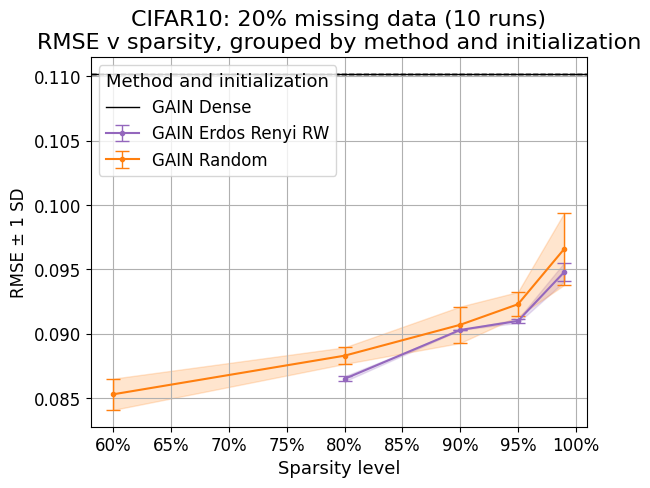

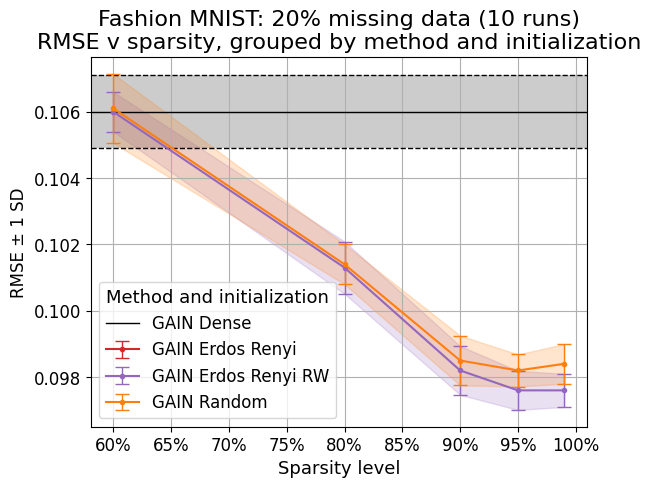

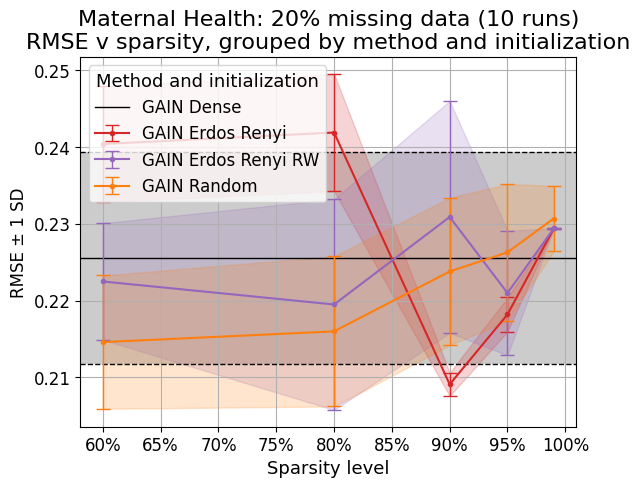

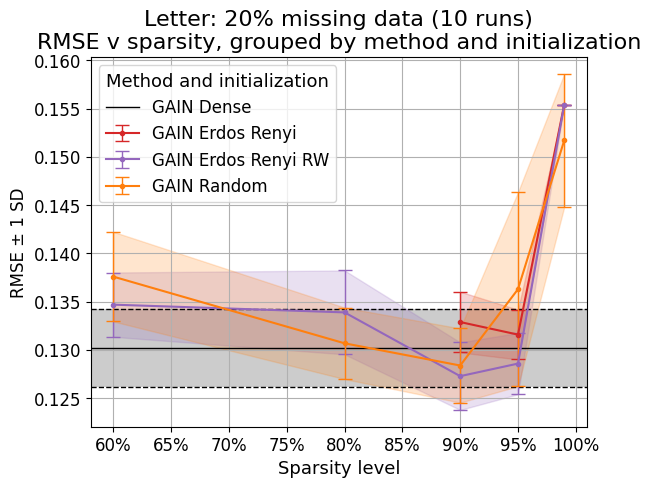

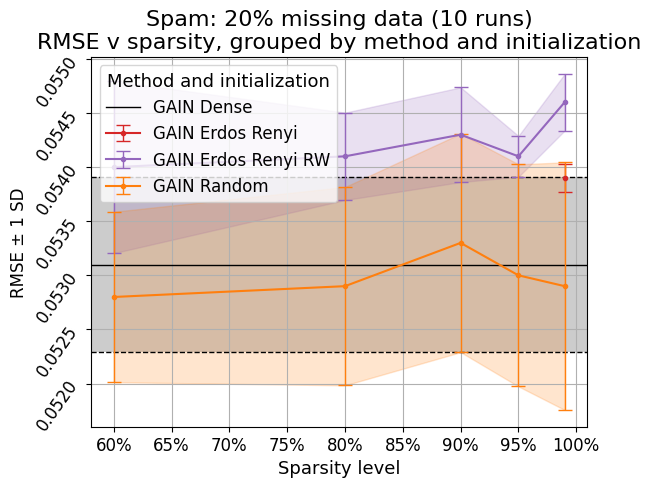

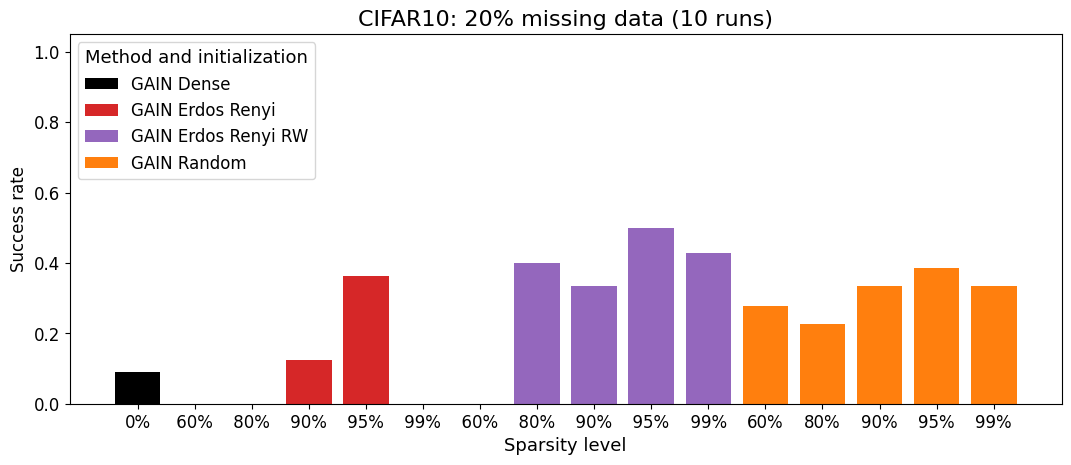

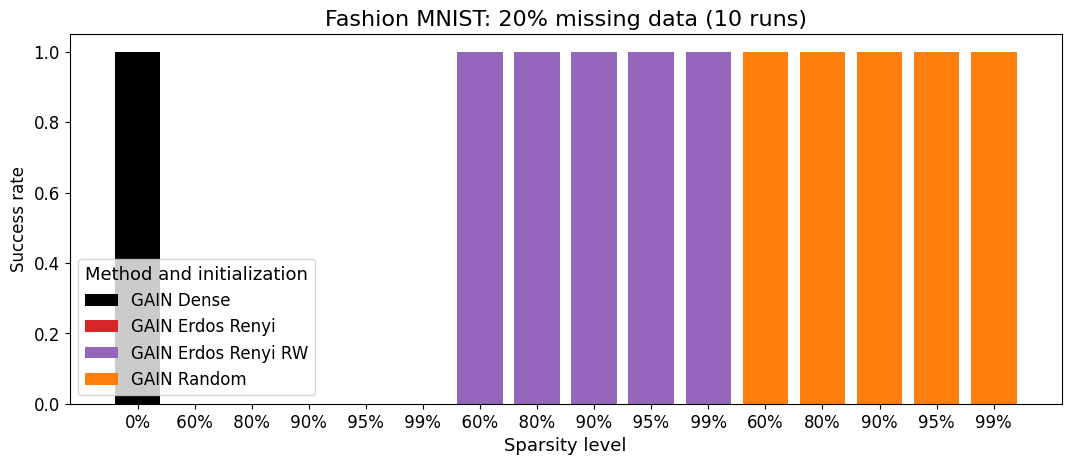

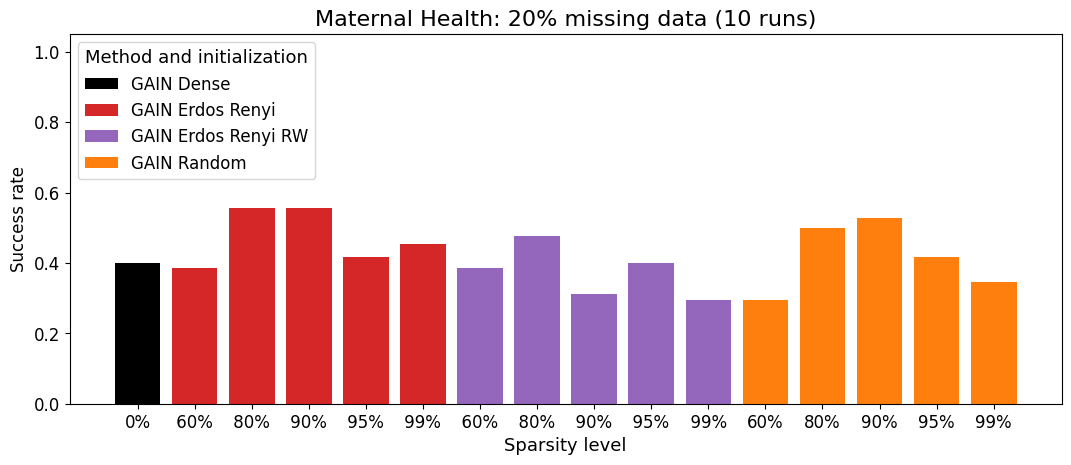

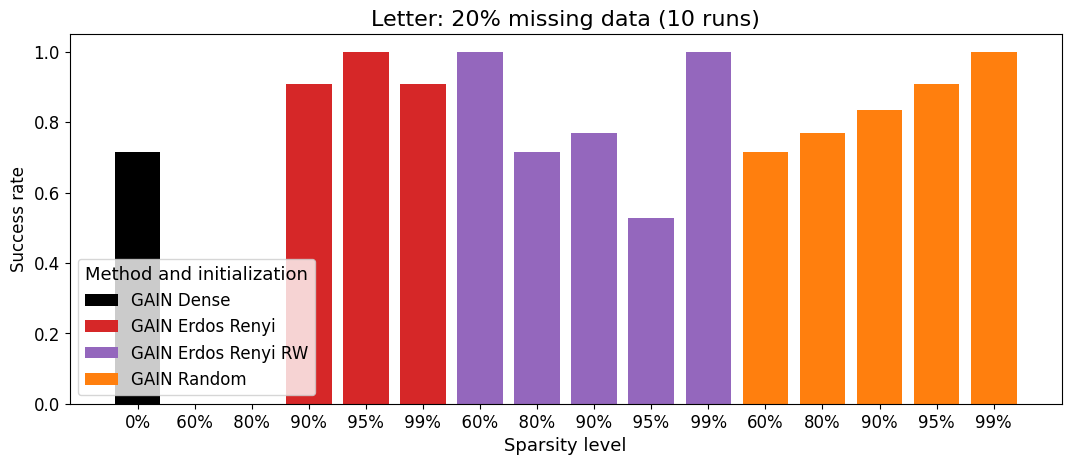

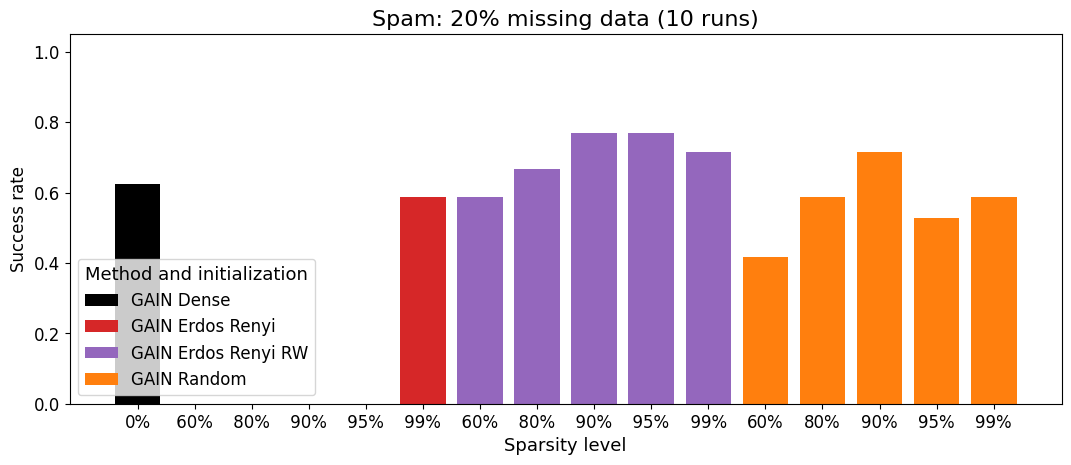

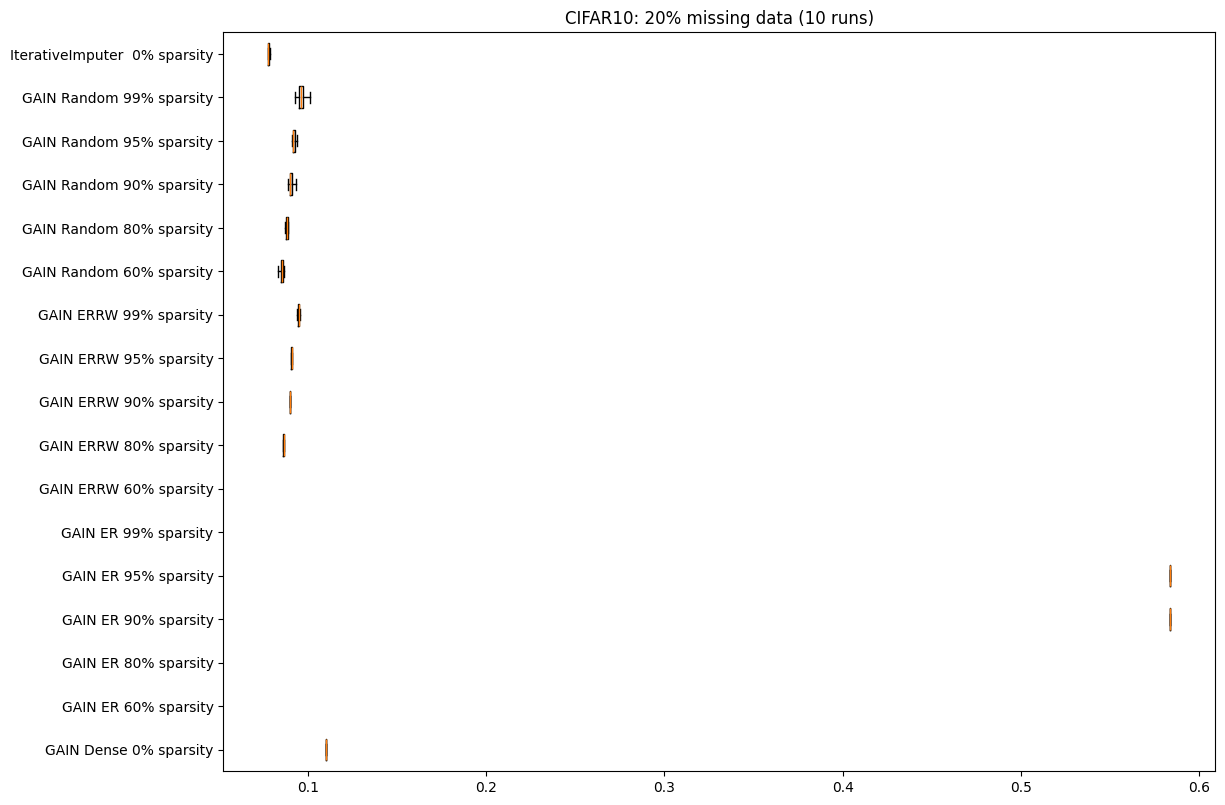

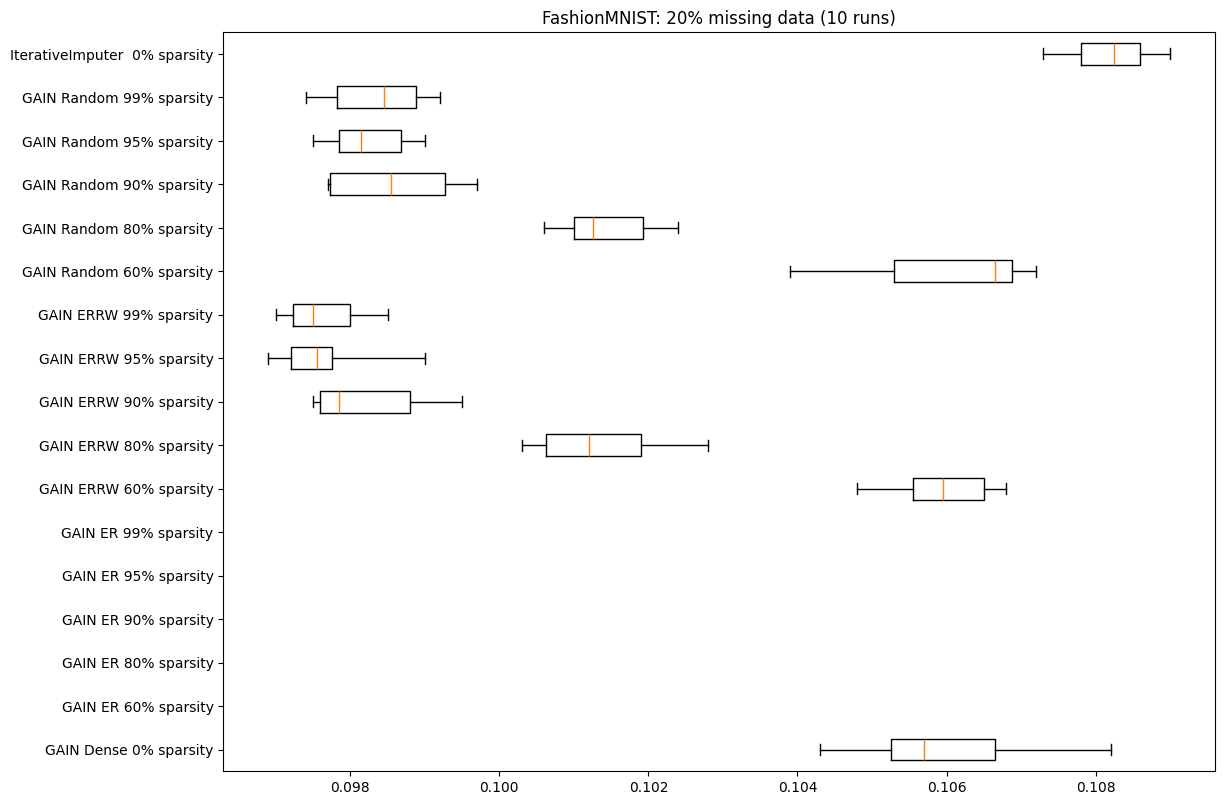

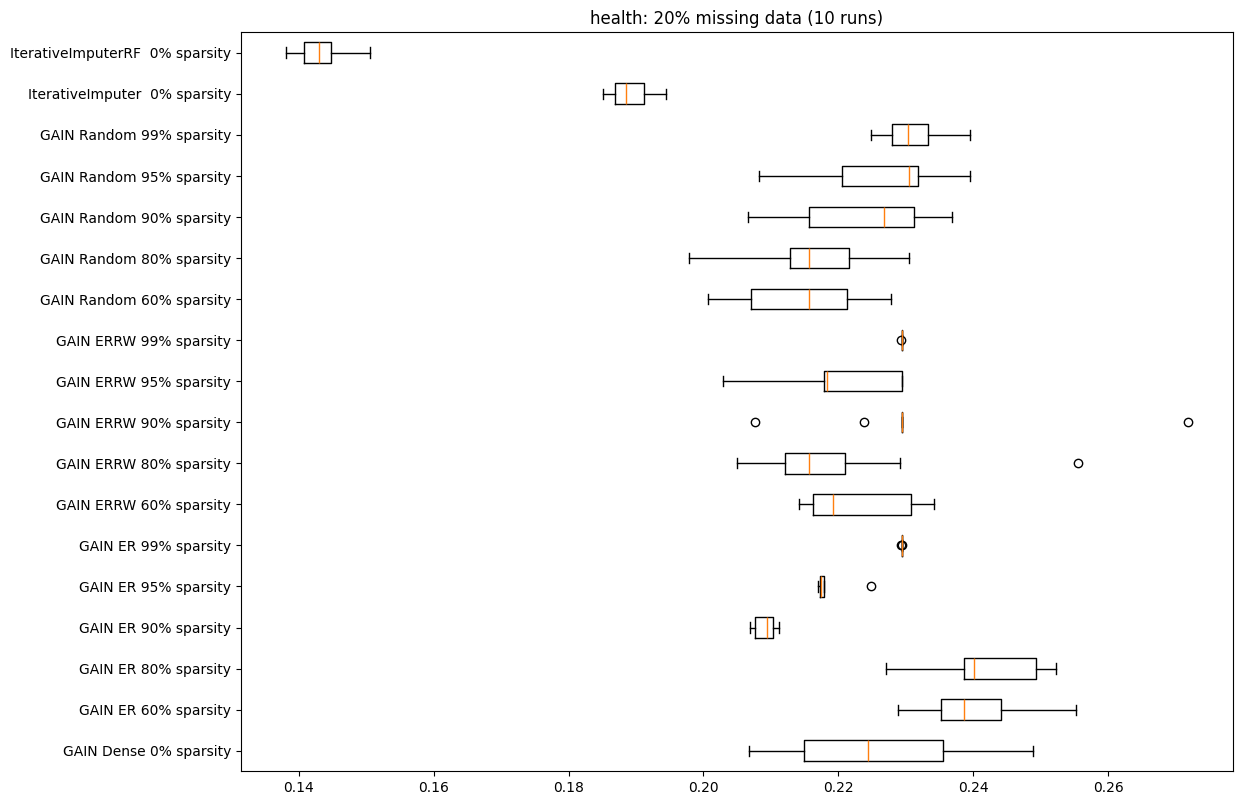

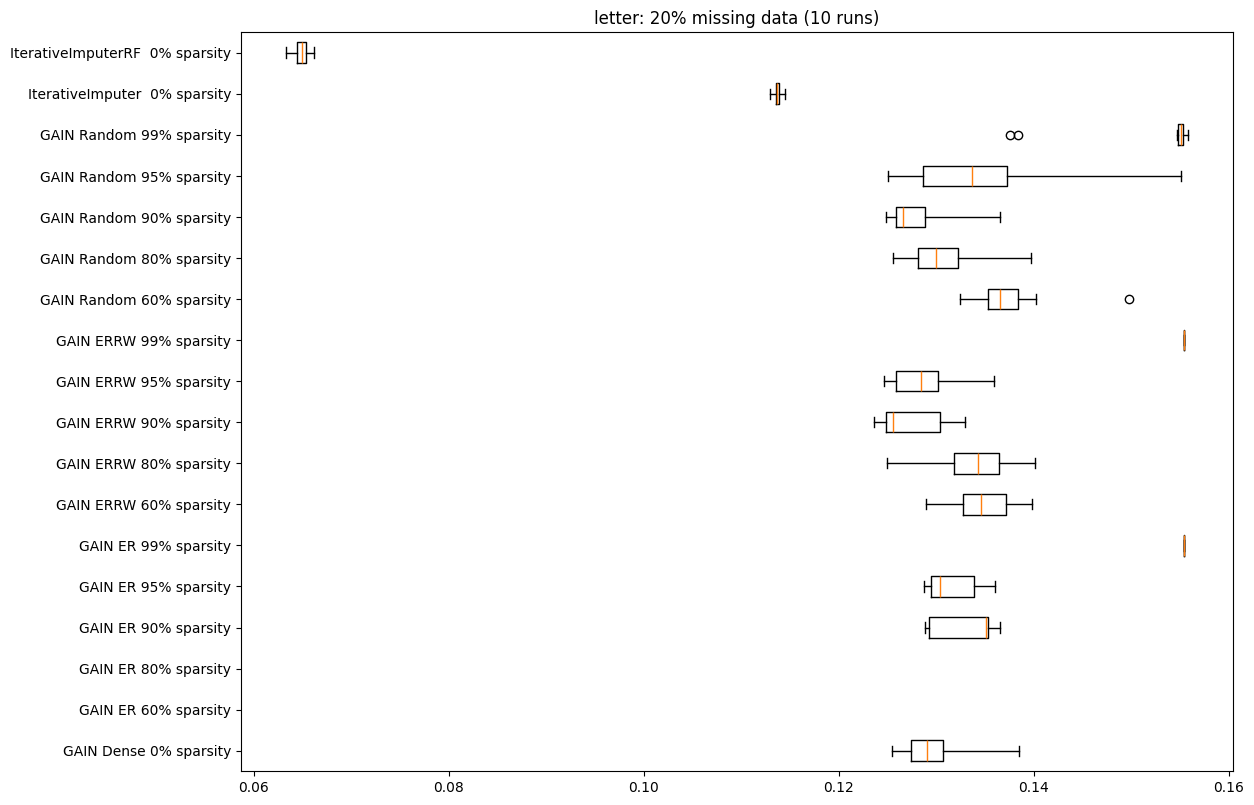

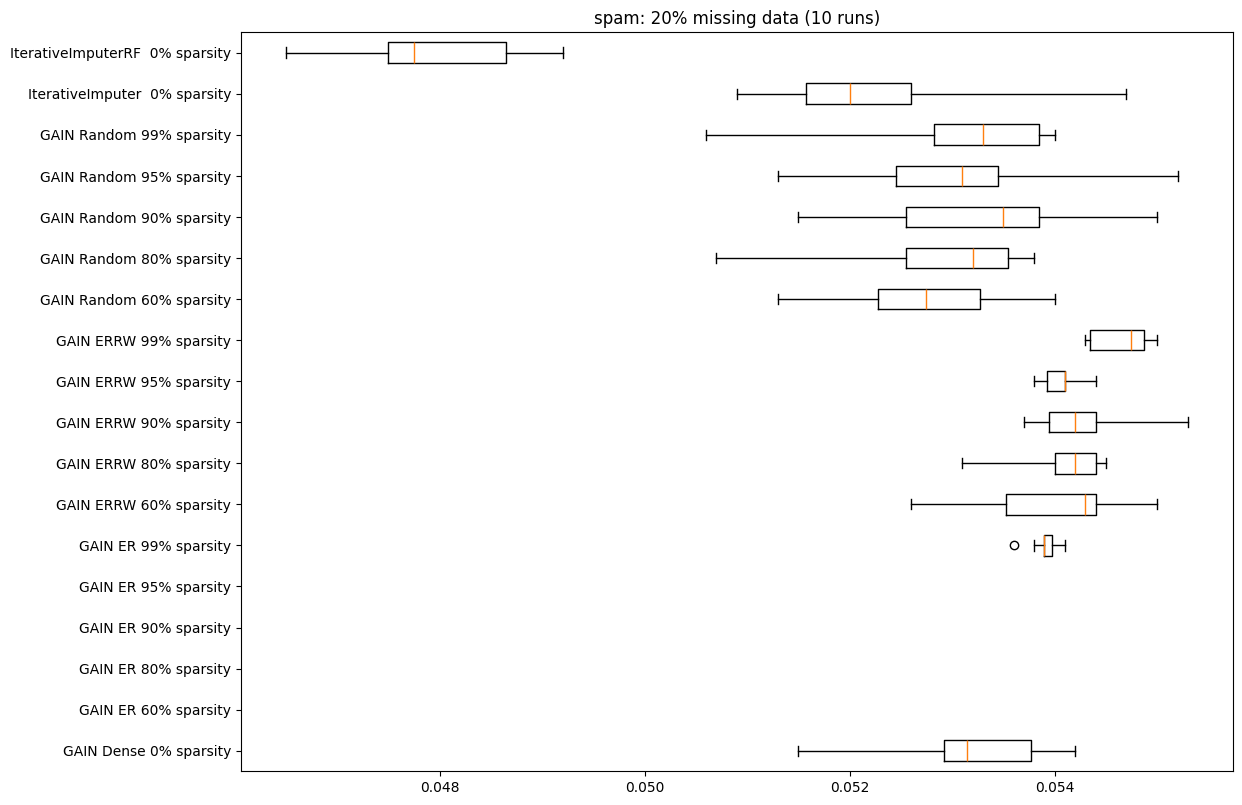

In [5]:
plot_rmse(metrics, save=True)
plot_success_rate(metrics, save=True)
box_plot(metrics, IQR=3)
# plot_flops()